In [96]:
# Common imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [97]:
# Import from utils
import sys
import importlib
sys.path.append('../')

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\USUARIO\\Desktop\\Projects\\4Geeks_temporal_series\\src\\water_spring\\..\\utils.py'>

# Combinación de datasets para el modelo

In [98]:
amiata = pd.read_csv("../../data/processed/water_spring_amiata.csv")
lupa = pd.read_csv("../../data/processed/water_spring_lupa.csv")
madonna = pd.read_csv("../../data/processed/water_spring_madonna.csv")

In [99]:
combined_df = pd.concat([amiata, lupa, madonna], ignore_index=True)

In [100]:
combined_df.to_csv("../../data/processed/combined_Water_Springs.csv", index=False)

In [101]:
combined_df

,Date,Rainfall,Temperature_S_Fiora,Flow_Rate_Lupa,Temperature_Settefrati
0,2000-01-01,1.4,-0.15,NaN,NaN
1,2000-01-02,1.4,1.55,NaN,NaN
2,2000-01-03,1.4,2.70,NaN,NaN
3,2000-01-04,1.4,4.00,NaN,NaN
4,2000-01-05,1.4,4.60,NaN,NaN
...,...,...,...,...,...
14794,NaN,0.0,NaN,NaN,5.1
14795,NaN,0.0,NaN,NaN,5.1
14796,NaN,0.0,NaN,NaN,5.1
14797,NaN,0.0,NaN,NaN,5.1


# Modelado

In [102]:
df = combined_df.sort_values(by=["Date"])

In [103]:
utils.get_null_percentage_per_column(df)

Temperature_Settefrati    78.964795
Flow_Rate_Lupa            71.626461
Temperature_S_Fiora       49.408744
Date                       0.060815
Rainfall                   0.000000
dtype: float64

In [104]:
# Interpolar valores nulos
df.interpolate(method='linear', limit_direction='both', inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13408\379664313.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', limit_direction='both', inplace=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13408\379664313.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13408\379664313.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [105]:
utils.get_null_percentage_per_column(df)

Date                      0.0
Rainfall                  0.0
Temperature_S_Fiora       0.0
Flow_Rate_Lupa            0.0
Temperature_Settefrati    0.0
dtype: float64

In [106]:
# Selección de variables
target_col = "Rainfall"  # Ajustar a la variable objetivo más representativa
feature_cols = [col for col in df.columns if col not in ["Date", target_col]]

In [107]:
# Normalización
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [108]:
df

,Date,Rainfall,Temperature_S_Fiora,Flow_Rate_Lupa,Temperature_Settefrati
0,2000-01-01,1.4,-1.712805,-1.663736,-0.659549
1,2000-01-02,1.4,-1.457204,-1.663736,-0.659549
2,2000-01-03,1.4,-1.284297,-1.663736,-0.659549
3,2000-01-04,1.4,-1.088837,-1.663736,-0.659549
4,2000-01-05,1.4,-0.998625,-1.663736,-0.659549
...,...,...,...,...,...
14794,2020-06-30,0.0,1.369444,1.307259,-0.682625
14795,2020-06-30,0.0,1.369444,1.307259,-0.682625
14796,2020-06-30,0.0,1.369444,1.307259,-0.682625
14797,2020-06-30,0.0,1.369444,1.307259,-0.682625


In [109]:
# Codificación de la variable categórica "Rainfall"
label_encoder = LabelEncoder()
df["Rainfall"] = label_encoder.fit_transform(df["Rainfall"])

In [110]:
# Dividir datos en entrenamiento y prueba (80%-20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [111]:
# Preparar datos para LSTM
def create_sequences(data, target_col, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][feature_cols + ["Rainfall"]].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, target_col, seq_length)
X_test, y_test = create_sequences(test, target_col, seq_length)

In [112]:
# Construcción del modelo LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
737/737 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 6494.5840 - val_loss: 6168.8330
Epoch 2/50
737/737 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 5560.4106 - val_loss: 6148.5229
Epoch 3/50
737/737 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 5287.4888 - val_loss: 6149.3643
Epoch 4/50
737/737 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/step - loss: 5407.9272 - val_loss: 6075.7202
Epoch 5/50
737/737 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - loss: 5216.6470 - val_loss: 6060.4062
Epoch 6/50
659/737 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 5144.8730

# Evaluación del modelo

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
MAE: 1.8363, RMSE: 2.2458


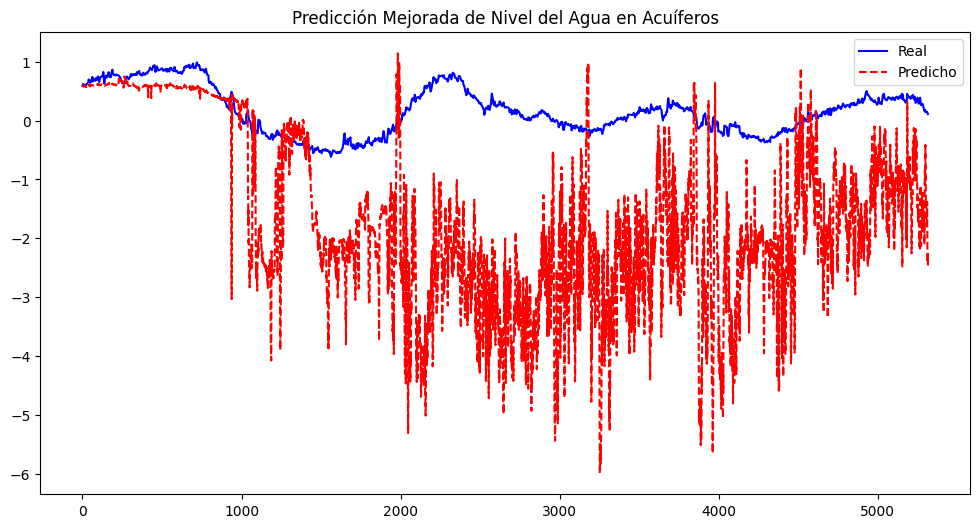

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color="blue")
plt.plot(y_pred, label="Predicho", color="red", linestyle="dashed")
plt.legend()
plt.show()
